#### Copyright 2018 Google LLC

This library is free software; you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public
License as published by the Free Software Foundation; either
version 2.1 of the License, or (at your option) any later version.



In [1]:
# This library is free software; you can redistribute it and/or
# modify it under the terms of the GNU Lesser General Public
# License as published by the Free Software Foundation; either
# version 2.1 of the License, or (at your option) any later version.
# 
# This library is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
# Lesser General Public License for more details.
# 
# You should have received a copy of the GNU Lesser General Public
# License along with this library; if not, write to the Free Software
# Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA

# Mitigating Unwanted Biases with Adversarial Learning

Authors: Andrew Zaldivar, Ben Hutchinson, Blake Lemoine, Brian Zhang, Margaret Mitchell

---


## Summary of this Notebook

This notebook is a guide to the paper ([archiv](https://arxiv.org/pdf/1801.07593.pdf))

> ```Brian Zhang, Blake Lemoine and Margaret Mitchell. Mitigating Unwanted Biases with Adversarial Learning. AAAI Conference on AI, Ethics and Society, 2018.```






## Intro statement of problem



Embeddings are a powerful mechanism for projecting a discrete variable (e.g. words, locales, urls) into a multi-dimensional real valued space.  Several strong methods have been developed for learning embeddings.  One example is the [Skipgram](http://www.cs.brandeis.edu/~marc/misc/proceedings/lrec-2006/pdf/357_pdf.pdf) algorithm.  In that algorithm the surrounding context is used to predict the presence of a word.  Unfortunately, much real world textual data has subtle bias that machine learning algorithms will implicitly include in the embeddings created from that data.  This bias can be illustrated by performing a word analogy task using the learned embeddings.

It is worth noting that the usages of terms like _fair_ and _bias_ are used in this notebook in the context of a particular definition of fairness sometimes referred to as "Demographic Parity" or "Equality of Outcomes" ([Hardt et. al 2016](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning)).  This definition of fairness effectively says that any relationship at all between a variable of interest and a _protected variable_ is an example of unwanted bias.  Other definitions of fairness such as "Equality of Odds" can be employed when there is believed to be some form of proper relationship between the variable of interest and the protected variable.  However, all uses of _fair_ and _bias_ here should be interpreted in the context of "Demographic Parity".


First, we'll import all the packages that we'll need.

In [2]:
# !pip install -U gensim~=3.2.0
import gensim
import gzip
import numpy as np
import os
import pandas as pd
# !pip install --upgrade-strategy=only-if-needed tensorflow~=1.6.0rc0
import tensorflow as tf

Now we'll sync the data for the colab to a tmp directory from Google Cloud Storage.

In [3]:

local_dir_name = 'data'

WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")


In [4]:
def load_word2vec_format(f, max_num_words=None):
  """Loads word2vec data from a file handle.

  Similar to gensim.models.keyedvectors.KeyedVectors.load_word2vec_format
  but takes a file handle as input rather than a filename. This lets us use
  GFile. Also only accepts binary files.

  Args:
    f: file handle
    max_num_words: number of words to load. If None, load all.

  Returns:
    Word2vec data as keyedvectors.EuclideanKeyedVectors.
  """
  header = f.readline()
  vocab_size, vector_size = (
      int(x) for x in header.rstrip().split())  # throws for invalid file format
  print "vector_size =  %d" % vector_size
  result = gensim.models.keyedvectors.EuclideanKeyedVectors()
  num_words = 0
  result.vector_size = vector_size
  result.syn0 = np.zeros((vocab_size, vector_size), dtype=np.float32)
  
  def add_word(word, weights):
    word_id = len(result.vocab)
    if word in result.vocab:
      print("duplicate word '%s', ignoring all but first", word)
      return
    result.vocab[word] = gensim.models.keyedvectors.Vocab(
        index=word_id, count=vocab_size - word_id)
    result.syn0[word_id] = weights
    result.index2word.append(word)

  if max_num_words and max_num_words < vocab_size:
    num_embeddings = max_num_words
  else:
    num_embeddings = vocab_size
  print "Loading %d embeddings" % num_embeddings
  
  binary_len = np.dtype(np.float32).itemsize * vector_size
  for _ in xrange(vocab_size):
    # mixed text and binary: read text first, then binary
    word = []
    while True:
      ch = f.read(1)
      if ch == b' ':
        break
      if ch == b'':
        raise EOFError("unexpected end of input; is count incorrect or file otherwise damaged?")
      if ch != b'\n':  # ignore newlines in front of words (some binary files have)
        word.append(ch)
    word = gensim.utils.to_unicode(b''.join(word), encoding='utf-8', errors='strict')
    weights = np.frombuffer(f.read(binary_len), dtype=np.float32)
    add_word(word, weights)
    num_words = num_words + 1
    if max_num_words and num_words == max_num_words:
      break
  if result.syn0.shape[0] != len(result.vocab):
    print(
        "duplicate words detected, shrinking matrix size from %i to %i",
        result.syn0.shape[0], len(result.vocab))
  result.syn0 = np.ascontiguousarray(result.syn0[:len(result.vocab)])
  assert (len(result.vocab), vector_size) == result.syn0.shape

  print("loaded %s matrix", result.syn0.shape)
  return result

In [5]:
%%time
# Initialize the embeddings client if this hasn't been done yet.
# For the efficiency of this notebook we just load the first 2M words, and don't
# re-initialize the client if it already exists. You could of course filter the
# word list in other ways.
if not 'client' in vars():
  print "Loading word embeddings from %s" % WORD2VEC_FILE
  with gzip.GzipFile(fileobj=open(WORD2VEC_FILE, 'r')) as f:
    client = load_word2vec_format(f, max_num_words=2000000)

Loading word embeddings from data/embeddings/GoogleNews-vectors-negative300.bin.gz
vector_size =  300
Loading 2000000 embeddings
('duplicate words detected, shrinking matrix size from %i to %i', 3000000, 2000000)
('loaded %s matrix', (2000000, 300))
CPU times: user 47.1 s, sys: 1.5 s, total: 48.6 s
Wall time: 48.9 s


The following blocks load a data file with analogy training examples and displays some of them as examples.  By changing the indices selected in the final block you can change which analogies from the training set are being displayed.

In [6]:
def print_knn(client, v, k):
  print "%d closest neighbors to A-B+C:" % k
  for neighbor, score in client.similar_by_vector(
      v.flatten().astype(float), topn=k):
    print "%s : score=%f" % (neighbor, score)

Let's take a look at the analogies that the model generates for *man*:*woman*::*boss*:$\underline{\quad}$.
Try changing ``"boss"`` to ``"friend"`` to see further examples of problematic analogies.

In [7]:
# Use a word embedding to compute an analogy
# Edit the parameters below to get different analogies
A = "asian"
B = "american"
C = "smart"
NUM_ANALOGIES = 5

in_arr = []
for i, word in enumerate((A, B, C)):
  in_arr.append(client.word_vec(word))
in_arr = np.array([in_arr])

print_knn(client, -in_arr[0, 0, :] + in_arr[0, 1, :] + in_arr[0, 2, :],
          NUM_ANALOGIES)

5 closest neighbors to A-B+C:
smart : score=0.668151
intelligent : score=0.454270
dumb : score=0.442581
smarter : score=0.412079
american : score=0.410000


In [8]:
def load_analogies(filename):
  """Loads analogies.

  Args:
    filename: the file containing the analogies.

  Returns:
    A list containing the analogies.
  """
  analogies = []
  with open(filename, "r") as fast_file:
    for line in fast_file:
      line = line.strip()
      # in the analogy file, comments start with :
      if line[0] == ":":
        continue
      words = line.split()
      # there are no misformatted lines in the analogy file, so this should
      # only happen once we're done reading all analogies.
      if len(words) != 4:
        print "Invalid line: %s" % line
        continue
      analogies.append(words)
  print "loaded %d analogies" % len(analogies)
  return analogies

In [9]:
analogies = load_analogies(ANALOGIES_FILE)
print "\n".join("%s is to %s as %s is to %s" % tuple(x) for x in analogies[-20:])

loaded 19544 analogies
write is to writes as increase is to increases
write is to writes as listen is to listens
write is to writes as play is to plays
write is to writes as predict is to predicts
write is to writes as provide is to provides
write is to writes as say is to says
write is to writes as scream is to screams
write is to writes as search is to searches
write is to writes as see is to sees
write is to writes as shuffle is to shuffles
write is to writes as sing is to sings
write is to writes as sit is to sits
write is to writes as slow is to slows
write is to writes as speak is to speaks
write is to writes as swim is to swims
write is to writes as talk is to talks
write is to writes as think is to thinks
write is to writes as vanish is to vanishes
write is to writes as walk is to walks
write is to writes as work is to works


## Adversarial Networks for Bias Mitigation

The method presented here for removing some of the bias from embeddings is based on the idea that those embeddings are intended to be used to predict some outcome $Y$ based on an input $X$ but that outcome should, in a fair world, be completely unrelated to some protected variable $Z$.  If that were the case then knowing $Y$ would not help you predict $Z$ any better than chance.  This principle can be directly translated into two networks in series as illustrated below.  The first attempts to predict $Y$ using $X$ as input.  The second attempts to use the predicted value of $Y$ to predict $Z$.  See Figure 1 of [the paper](https://arxiv.org/pdf/1801.07593.pdf).

However, simply training the weights in W based on $\nabla_WL_1$ and the weights in $U$ based on $\nabla_UL_2$ won’t actually achieve an unbiased model.  In order to do that you need to incorporate into $W$’s update function the concept that $U$ should be no better than chance at predicting $Z$.  The way that you can achieve that is analogous to how Generative Adversarial Networks (GANs) ([Goodfellow et al. 2014](http://papers.nips.cc/paper/5423-generative-adversarial-nets)) train their generators.

In addition to $\nabla_WL_1$ you incorporate the negation of $\nabla_WL_2$ into $W$’s update function.  However, it’s possible that $\nabla_WL_1$ is changing $W$ in a way which will improve accuracy by using the biased information you are trying to protect.  In order to avoid that you also incorporate a term which removes that component of $\nabla_WL_1$ by projecting it onto $\nabla_WL_2$.  Once you’ve incorporated those two terms, the update function for $W$ becomes:


$\nabla_WL_1-proj_{(\nabla_WL_2)}\nabla_WL_1 - \nabla_WL_2$



### Defining the Protected Variable of Embeddings

The description of how to incorporate adversarial networks into machine learned models above is very generic because the technique is generally applicable for any type of systems which can be described in terms of input $X$ being predictive of $Y$ but potentially containing information about a protected variable $Z$.  So long as you can construct the relevant update functions you can apply this technique.  However, that doesn’t tell you much about the nature of $X$, $Y$ and $Z$.  In the case of the word analogies task above, $X = B + C - A$ and $Y = D$.  Figuring out what $Z$ should be is a little bit trickier though.  For that we can look to a paper by [Bulokbasi et. al.](http://papers.nips.cc/paper/6227-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings) where they developed an unsupervised methodology for removing gendered semantics from word embeddings.

The first step is to select pairs of words which are relevant to the type of bias you are trying to remove.  In the case of gender you can choose word pairs like “man”:”woman” and “boy”:girl” which have gender as the only difference in their semantics.  Once you have these word pairs you can compute the difference between their embeddings to produce vectors in the embeddings’ semantic space which are roughly parallel to the semantics of gender.  Performing Principal Components Analysis (PCA) on those vectors then gives you the major components of the semantics of gender as defined by the gendered word pairs provided.


In [10]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)


def load_vectors(client, analogies):
  """Loads and returns analogies and embeddings.

  Args:
    client: the client to query.
    analogies: a list of analogies.

  Returns:
    A tuple with:
    - the embedding matrix itself
    - a dictionary mapping from strings to their corresponding indices
      in the embedding matrix
    - the list of words, in the order they are found in the embedding matrix
  """
  words_unfiltered = set()
  for analogy in analogies:
    words_unfiltered.update(analogy)
  print "found %d unique words" % len(words_unfiltered)

  vecs = []
  words = []
  index_map = {}
  for word in words_unfiltered:
    try:
      vecs.append(_np_normalize(client.word_vec(word)))
      index_map[word] = len(words)
      words.append(word)
    except KeyError:
      print "word not found: %s" % word
  print "words not filtered out: %d" % len(words)

  return np.array(vecs), index_map, words

In [11]:
embed, indices, words = load_vectors(client, analogies)

embed_dim = len(embed[0].flatten())
print "word embedding dimension: %d" % embed_dim

found 905 unique words
words not filtered out: 905
word embedding dimension: 300


In [12]:
def find_gender_direction(embed,
                          indices):
  """Finds and returns a 'gender direction'."""
  pairs = [
      ("woman", "man"),
      ("her", "his"),
      ("she", "he"),
      ("aunt", "uncle"),
      ("niece", "nephew"),
      ("daughters", "sons"),
      ("mother", "father"),
      ("daughter", "son"),
      ("granddaughter", "grandson"),
      ("girl", "boy"),
      ("stepdaughter", "stepson"),
      ("mom", "dad"),
  ]
  m = []
  for wf, wm in pairs:
    m.append(embed[indices[wf]] - embed[indices[wm]])
  m = np.array(m)

  # the next three lines are just a PCA.
  m = np.cov(np.array(m).T)
  evals, evecs = np.linalg.eig(m)
  return _np_normalize(np.real(evecs[:, np.argmax(evals)]))

In [13]:
# Using the embeddings, find the gender vector.
gender_direction = find_gender_direction(embed, indices)
print "gender direction: %s" % str(gender_direction.flatten())

gender direction: [-7.94102556e-02 -8.62907447e-02 -9.36046086e-02 -6.82094699e-02
  2.10405600e-02  9.09854549e-03  3.69967887e-02  6.76862493e-03
 -1.35619514e-01  3.62402266e-02  6.62573091e-02 -9.91207519e-04
  4.59588196e-02 -6.13280986e-02 -2.14388384e-03 -1.15234663e-02
 -7.85432247e-02 -6.24935300e-02 -8.79221813e-02 -1.73189498e-02
  1.72767315e-02  1.72292006e-03 -3.53863093e-02  5.24758140e-03
  1.45531278e-02  7.97479425e-03 -3.40466363e-02 -2.83068019e-02
 -1.02746018e-01 -1.78703381e-01 -1.88934471e-02 -7.23408473e-02
 -1.06853722e-01 -4.48557103e-02 -5.89368281e-03 -7.94341237e-02
  1.17833895e-03 -5.86551743e-02  3.10732848e-02 -3.12044830e-03
 -4.15907969e-02 -7.17691663e-03 -2.56242105e-02 -3.41547309e-02
 -6.38683437e-02  7.83023380e-02  1.41320146e-03 -1.92862106e-02
  4.27428205e-02  6.23987501e-03  2.58495545e-02 -2.53252181e-02
 -6.58270803e-03  6.81094699e-02  2.29536006e-02 -3.01465541e-02
 -8.76620455e-03 -3.48142318e-03 -1.03283556e-02 -4.43229749e-02
  4.820

Once you have the first principal component of the embedding differences, you can start projecting the embeddings of words onto it.  That projection is roughly the degree to which a word is relevant to the latent protected variable defined by the first principle component of the word pairs given.  This projection can then be taken as the protected variable $Z$ which the adversary is attempting to predict on the basis of the predicted value of $Y$.  The code below illustrates how to construct a function which computes $Z$ from $X$ in this way.

Try editing the WORD param in the next cell to see the projection of other words onto the gender direction.

In [14]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [15]:
embeddings = client

In [16]:
from matplotlib import pyplot as plt

In [17]:
from sklearn.model_selection import train_test_split


In [18]:
pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
train_vectors, test_vectors, train_targets, test_targets = train_test_split(vectors, targets, test_size=0.1, random_state=0)

In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='auto').fit(train_vectors,train_targets)
clf.score(test_vectors,test_targets)


0.946031746031746

<BarContainer object of 100 artists>

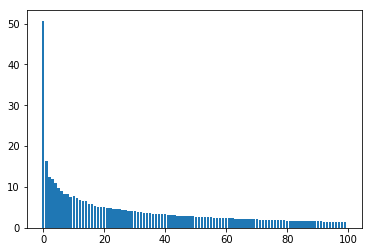

In [20]:
import nltk 
from nltk.corpus import wordnet 
good = []
bad=  []

for word in pos_words:
    a = wordnet.synsets(word)
    if len(a)>0:
        syn = a[0] .lemmas()[0]
        if len(syn.antonyms())>0:
            good.append(word)
            bad.append(syn.antonyms()[0].name()) 
            
good_vectors=[]
bad_vectors = []
# good = ['good','beautiful','happy','positive','compentent','smart','interesting','pleasant','best','honest','wealthy','wonderful']
# bad = ['bad','ugly','sad','negative','incompetent','dumb','boring','horrible','worst','corrupt','poor','awful']
# good = ['amazing']
# bad = ['horrible']
choices = np.random.choice(len(good),20)
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.dot(X.T,X)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

In [21]:
WORD = "polish"
word_vec = _np_normalize(client.word_vec(WORD))
print word_vec.dot(vec)

0.06925793


In [22]:
np.shape(vec)

(300,)

In [23]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
    'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
    'Diasporic',
    'Sikh',
    'Juche',
    'Jewish',
    'Bahai',
    'Jains',
    'Shinto',
    'Pagan'
]
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

In [24]:
words = gender#filter(lambda x: x.lower() in embeddings,identities)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: embeddings[w.lower()].dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df

      word  sentiment_score
0     male        -0.222274
6      boy        -0.204027
7     girl        -0.202659
5    woman        -0.156328
4      man        -0.127307
9     hers        -0.111194
3      him        -0.091149
8      his        -0.068180
2      her        -0.054850
1   female        -0.044018
10     mom         0.029774
11     dad         0.072020


Let's now look at the words with the largest *negative* projection onto the gender dimension.

In [25]:
words = set()
for a in analogies:
  words.update(a)

df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: client.word_vec(w).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df.head(10)


              word  sentiment_score
304   unproductive        -1.271479
217     irrational        -1.159424
45   uncompetitive        -1.143645
380    inefficient        -1.130281
428     uninformed        -1.116056
579  irresponsible        -1.095759
83       illogical        -1.091005
743      dishonest        -1.057061
21   uninformative        -1.034158
503   unacceptable        -1.017415


Let's now look at the words with the largest *positive* projection onto the gender dimension.

In [26]:
df.sort_values(by="sentiment_score", inplace=True, ascending=False)
print df.head(10)

            word  sentiment_score
711       widest         0.962137
425    efficient         0.860398
370     sweetest         0.804517
283    fortunate         0.728857
14      tastiest         0.724279
415  comfortable         0.714410
115        great         0.703595
568  efficiently         0.703564
51   informative         0.689995
829    enhancing         0.677500


### Training the model

Training adversarial networks is hard. They are touchy, and if touched the wrong way, they blow up VERY quickly. One must be very careful to train both models slowly enough, so that the parameters in the models do not diverge. In practice, this usually entails significantly lowering the step size of both the classifier and the adversary. It is also probably beneficial to initialize the parameters of the adversary to be extremely small, to ensure that the classifier does not overfit against a particular (sub-optimal) adversary (such overfitting can very quickly cause divergence!).  It is also possible that if the classifier is too good at hiding the protected variable from the adversary then the adversary will impose updates that diverge in an effort to improve its performance.  The solution to that can sometimes be to actually increase the adversary’s learning rate to prevent divergence (something almost unheard of in most learning systems).  Below is a system for learning the debiasing model for word embeddings described above.  

Inspect the terminal output for the kernel to inspect the performance of the model. Try modifying the hyperparameters at the top to see how that impacts the convergence properties of the system.

In [67]:
tf.reset_default_graph()
def tf_normalize(x):
  """Returns the input vector, normalized.

  A small number is added to the norm so that this function does not break when
  dealing with the zero vector (e.g. if the weights are zero-initialized).

  Args:
    x: the tensor to normalize
  """
  return x / (tf.norm(x) + np.finfo(np.float32).tiny)


class AdversarialEmbeddingModel(object):
  """A model for doing adversarial training of embedding models."""

  def __init__(self, client,
               data_p, embed_dim, projection,
               projection_dims, pred,X,Y,X_test,Y_test):
    """Creates a new AdversarialEmbeddingModel.

    Args:
      client: The (possibly biased) embeddings.
      data_p: Placeholder for the data.
      embed_dim: Number of dimensions used in the embeddings.
      projection: The space onto which we are "projecting".
      projection_dims: Number of dimensions of the projection.
      pred: Prediction layer.
    """
    # load the analogy vectors as well as the embeddings
    self.client = client
    self.data_p = data_p
    self.embed_dim = embed_dim
    self.projection = projection
    self.projection_dims = projection_dims
    self.pred = pred
    self.X=X
    self.Y=Y
    self.X_test = X_test
    self.Y_test = Y_test

  def nearest_neighbors(self, sess, in_arr,
                        k):
    """Finds the nearest neighbors to a vector.

    Args:
      sess: Session to use.
      in_arr: Vector to find nearest neighbors to.
      k: Number of nearest neighbors to return
    Returns:
      List of up to k pairs of (word, score).
    """
    v = sess.run(self.pred, feed_dict={self.data_p: in_arr})
    return self.client.similar_by_vector(v.flatten().astype(float), topn=k)

  def write_to_file(self, sess, f):
    """Writes a model to disk."""
    np.savetxt(f, sess.run(self.projection))

  def read_from_file(self, sess, f):
    """Reads a model from disk."""
    loaded_projection = np.loadtxt(f).reshape(
        [self.embed_dim, self.projection_dims])
    sess.run(self.projection.assign(loaded_projection))
    
  def fit(self,
          sess,
          data,
          data_p,
          labels,
          labels_p,
          protect,
          protect_p,
          gender_direction,
          pred_learning_rate,
          protect_learning_rate,
          protect_loss_weight,
          num_steps,
          batch_size,
          debug_interval=1000):
    """Trains a model.

    Args:
      sess: Session.
      data: Features for the training data.
      data_p: Placeholder for the features for the training data.
      labels: Labels for the training data.
      labels_p: Placeholder for the labels for the training data.
      protect: Protected variables.
      protect_p: Placeholder for the protected variables.
      gender_direction: The vector from find_gender_direction().
      pred_learning_rate: Learning rate for predicting labels.
      protect_learning_rate: Learning rate for protecting variables.
      protect_loss_weight: The constant 'alpha' found in
          debias_word_embeddings.ipynb.
      num_steps: Number of training steps.
      batch_size: Number of training examples in each step.
      debug_interval: Frequency at which to log performance metrics during
          training.
    """
    #################################################################
    learning_rate = 0.001
    training_epochs = 100
    batch_size = 100
    display_step = 1


    # Network Parameters
    n_hidden_1 = 10 # 1st layer number of features
    n_hidden_2 = 10 # 2nd layer number of features
    n_input = 300 # Number of feature
    n_classes = 2 # Number of classes to predict


    # tf Graph input
    x = tf.placeholder("float", [None, n_input])
    y = tf.placeholder("float", [None, n_classes])
    y_targets = tf.placeholder("float", [None, n_classes])

    # Create model
    def multilayer_perceptron(x, weights, biases):
        # Hidden layer with RELU activation
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        layer_1 = tf.nn.relu(layer_1)
        # Hidden layer with RELU activation
        layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
        layer_2 = tf.nn.relu(layer_2)
        # Output layer with linear activation
        out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
        return out_layer

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
    }

    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    # Construct model
    pred = multilayer_perceptron(x, weights, biases)

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    ##########################
    feed_dict = {
        data_p: data,
        labels_p: labels,
        protect_p: protect,
    }
    # define the prediction loss
    pred_loss = tf.losses.mean_squared_error(labels_p, self.pred)

    # compute the prediction of the protected variable.
    # The "trainable"/"not trainable" designations are for the predictor. The
    # adversary explicitly specifies its own list of weights to train.
#     protect_weights = tf.get_variable(
#         "protect_weights", [self.embed_dim, 1], trainable=False)
    
#     protect_pred = tf.matmul(self.pred, protect_weights)#changr
#     protect_loss = tf.losses.mean_squared_error(protect_p, protect_pred)

    pred_cr = multilayer_perceptron(self.pred, weights, biases)
    protect_loss =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_cr, labels=y_targets))
    print protect_loss

    pred_opt = tf.train.AdamOptimizer(pred_learning_rate)
#     protect_opt = tf.train.AdamOptimizer(protect_learning_rate)

    protect_grad = {v: g for (g, v) in pred_opt.compute_gradients(protect_loss)}
    pred_grad = []

    # applies the gradient expression found in the document linked
    # at the top of this file.
    for (g, v) in pred_opt.compute_gradients(pred_loss):
      unit_protect = tf_normalize(protect_grad[v])
      # the two lines below can be commented out to train without debiasing
      g -= tf.reduce_sum(g * unit_protect) * unit_protect
      g -= protect_loss_weight * protect_grad[v]
      pred_grad.append((g, v))
      pred_min = pred_opt.apply_gradients(pred_grad)

    # compute the loss of the protected variable prediction.
#     protect_min = protect_opt.minimize(protect_loss, var_list=[protect_weights])
  # Parameters

    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    #####################################################################
    
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(self.X)/batch_size)
        X_batches = np.array_split(self.X, total_batch)
        Y_batches = np.array_split(self.Y, total_batch)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            # Run optimization op (backprop) and cost op (to get loss value)
            print np.array([[.5,.5]]*len(batch_y)), batch_y
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y,
                                                         y_targets:np.array([[.5,.5]]*len(batch_y))
 })
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: self.X_test, y: self.Y_test}))
    global result 
    result = tf.argmax(pred, 1).eval({x: self.X_test, y: self.Y_test})
    ###############################################################################
    step = 0
    while step < num_steps:
      # pick samples at random without replacement as a minibatch
      ids = np.random.choice(len(data), batch_size, False)
      data_s, labels_s, protect_s = data[ids], labels[ids], protect[ids]
      sgd_feed_dict = {
          data_p: data_s,
          labels_p: labels_s,
          protect_p: protect_s,
      }

      if not step % debug_interval:
        metrics = [pred_loss, protect_loss, self.projection]
        metrics_o = sess.run(metrics, feed_dict=feed_dict)
        pred_loss_o, protect_loss_o, proj_o = metrics_o
        # log stats every so often: number of steps that have passed,
        # prediction loss, adversary loss
        print("step: %d; pred_loss_o: %f; protect_loss_o: %f" % (step,
                     pred_loss_o, protect_loss_o))
        for i in range(proj_o.shape[1]):
          print("proj_o: %f; dot(proj_o, gender_direction): %f)" %
                       (np.linalg.norm(proj_o[:, i]),
                       np.dot(proj_o[:, i].flatten(), gender_direction)))
      sess.run([pred_min, protect_min], feed_dict=sgd_feed_dict)
      step += 1
      
def filter_analogies(analogies,
                     index_map):
  filtered_analogies = []
  for analogy in analogies:
    if filter(index_map.has_key, analogy) != analogy:
      print "at least one word missing for analogy: %s" % analogy
    else:
      filtered_analogies.append(map(index_map.get, analogy))
  return filtered_analogies

def make_data(
    analogies, embed,
    gender_direction):
  """Preps the training data.

  Args:
    analogies: a list of analogies
    embed: the embedding matrix from load_vectors
    gender_direction: the gender direction from find_gender_direction

  Returns:
    Three numpy arrays corresponding respectively to the input, output, and
    protected variables.
  """
  data = []
  labels = []
  protect = []
  for analogy in analogies:
    # the input is just the word embeddings of the first three words
    data.append(embed[analogy[:3]])
    # the output is just the word embeddings of the last word
    labels.append(embed[analogy[3]])
    # the protected variable is the gender component of the output embedding.
    # the extra pair of [] is so that the array has the right shape after
    # it is converted to a numpy array.
    protect.append([np.dot(embed[analogy[3]], gender_direction)])
  # Convert all three to numpy arrays, and return them.
  return tuple(map(np.array, (data, labels, protect)))

Edit the training parameters below to experiment with different training runs.

For example, try increasing the number of training steps to 50k.

In [68]:
analogy_indices = filter_analogies(analogies, indices)

data, labels, protect = make_data(analogy_indices, embed, vec)
np.shape(data),np.shape(labels),np.shape(protect)

((19544, 3, 300), (19544, 300), (19544, 1))

In [69]:
tf.reset_default_graph()


In [70]:
# Edit the training parameters below to experiment with different training runs.
# For example, try 
pred_learning_rate = 2**-16
protect_learning_rate = 2**-16
protect_loss_weight = 4
num_steps = 30000
batch_size = 1000

embed_dim = 300
projection_dims = 1

Y = np.array([targets, -(targets-1)]).T  # The model currently needs one column for each class
X, X_test, Y, Y_test = train_test_split(vectors, Y)
sess = tf.InteractiveSession()
with tf.variable_scope('var_scope', reuse=tf.AUTO_REUSE):
    
    analogy_indices = filter_analogies(analogies, indices)

    data, labels, protect = make_data(analogy_indices, embed, vec)
    data_p = tf.placeholder(tf.float32, shape=[None, 3, embed_dim], name="data")
    labels_p = tf.placeholder(tf.float32, shape=[None, embed_dim], name="labels")
    protect_p = tf.placeholder(tf.float32, shape=[None, 1], name="protect")

    # projection is the space onto which we are "projecting". By default, this is
    # one-dimensional, but this can be tuned by projection_dims
    projection = tf.get_variable("projection", [embed_dim, projection_dims])

    # build the prediction layer
    # pred is the simple computation of d = -a + b + c for a : b :: c : d
    pred = -data_p[:, 0, :] + data_p[:, 1, :] + data_p[:, 2, :]
    pred -= tf.matmul(tf.matmul(pred, projection), tf.transpose(projection))

    trained_model = AdversarialEmbeddingModel(
        client, data_p, embed_dim, projection, projection_dims, pred,X,Y,X_test,Y_test)

    trained_model.fit(sess, data, data_p, labels, labels_p, protect, protect_p, vec,
              pred_learning_rate,
            protect_learning_rate, protect_loss_weight, num_steps, batch_size)

Tensor("var_scope/Mean_1:0", shape=(), dtype=float32)


ValueError: None values not supported.

### Analogy generation using the embeddings with bias reduced by the adversarial model

Let's see how the model that has been trained to mitigate bias performs on the analogy task.
As before, change "boss" to "friend" to see how those analogies have changed too.


In [ ]:
table = {}
table1 = {}
for i in analogies:
    for j in i:
        if not j in table:
            table[j.lower()] = 1
            table1[j.lower()] = [i]
        else: 
            table1[j.lower()].append(i)
            table[j.lower()]+=1

In [ ]:
for i in nationalities:
    if i.lower() in table1:
        print table1[i.lower()],i

In [ ]:
for i in nationalities:
    if i.lower() in table:
        print table[i.lower()],i

In [ ]:
w= trained_model.projection.eval()


In [ ]:
client.similar_by_vector(embeddings['amazing'])

In [ ]:
client.similar_by_vector(embeddings['american'])

In [ ]:
client.similar_by_vector(embeddings['american']-np.dot(np.dot(w,w.T),embeddings['american']))

In [ ]:
words= filter(lambda x: x.lower() in embeddings,nationalities)

In [ ]:
%matplotlib inline
w= trained_model.projection.eval()
W = np.dot(w,w.T)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda a: clf.predict_proba([embeddings[a.lower()]-np.dot(np.dot(w,w.T),embeddings[a.lower()])])[0][1])
df.sort_values(by="sentiment_score", inplace=True)
df.plot.bar(x="word",y="sentiment_score")

In [ ]:
w= trained_model.projection.eval()
W = np.dot(w,w.T)
words = nationalities#filter(lambda x: x.lower() in embeddings,identities)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
df.plot.bar(x="word",y="sentiment_score")


In [ ]:
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda a: embeddings[a.lower()].dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
df.plot.bar(x="word",y="sentiment_score")


In [ ]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda w: clf.predict_proba([embeddings[w.lower()]])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
df.plot.bar(x="word",y="prob_neg_sentiment")


In [ ]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda a: clf.predict_proba([(embeddings[a.lower()]-np.dot(np.dot(w,w.T),embeddings[a.lower()]))])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
df.plot.bar(x="word",y="prob_neg_sentiment")

In [ ]:
identity_toxicity_debias = dict(identity_toxicity_table(nationalities, embeddings,lr))
identity_toxicity = dict(identity_toxicity_table(nationalities,embeddings,lr))
# keys_common = set(map(lambda x : x[6:] , identity_toxicity_debias.keys())).intersection(set(identity_toxicity.keys()))
# identity_toxicity_debias = {key: identity_toxicity_debias[key] for key in keys_common }
# identity_toxicity = {key: identity_toxicity[key] for key in keys_common }
identity_toxicity_debias = zip(*identity_toxicity_debias.items())
identity_toxicity = zip(*identity_toxicity.items())
%matplotlib inline
f = plt.figure(figsize=(27, 18), dpi= 80, facecolor='w', edgecolor='k')
f.subplots_adjust(hspace=1.2)
f.add_subplot(411)
plt.title("GloVe Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,identity_toxicity[1]/np.sum(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(412)
plt.title("GloVe Kernel Negative Sentiment Distribution",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
plt.bar(index,identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1]))
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
f.add_subplot(413)
plt.title("Delta Between Word Embedding Distributions",fontsize=35)
index = np.arange(len(identity_toxicity_debias[0]))
delta = identity_toxicity[1]/np.sum(identity_toxicity[1])-identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
bar = plt.bar(index,delta)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, identity_toxicity_debias[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=-.06)
f.add_subplot(414)
plt.title('Fair Uniform Taget Distribution',fontsize=35)
index = np.arange(len(identity_toxicity[0]))
plt.bar(index,1./len(identity_toxicity[1]))
plt.xticks(index, identity_toxicity[0], fontsize=25, rotation=35)
plt.ylim(top=.2,bottom=0)
plt.show()
uniform_dist = np.ones(len(identity_toxicity[1]))*1./len(identity_toxicity[1])
uniform_dist_d = np.ones(len(identity_toxicity_debias[1]))*1./len(identity_toxicity_debias[1])

debiased_normalized = identity_toxicity_debias[1]/np.sum(identity_toxicity_debias[1])
biased_normalized = identity_toxicity[1]/np.sum(identity_toxicity[1])
kl_debiased = (debiased_normalized * np.log(debiased_normalized/uniform_dist_d)).sum()
kl_biased = (biased_normalized * np.log(biased_normalized/uniform_dist)).sum()
print 'kl divergence from uniform dist for concept net:',kl_debiased
print 'kl divergence from uniform dist for google news:',kl_biased

In [ ]:
# Parameters
A = "american"
B = "mexican"
C = "good"
NUM_ANALOGIES = 5

# Use a word embedding to compute an analogy
in_arr = []
for i, word in enumerate((A, B, C)):
  in_arr.append(client.word_vec(word))
in_arr = np.array([in_arr])

print_knn(client, sess.run(pred, feed_dict={data_p: in_arr}),
          NUM_ANALOGIES)

##Conclusion

The method demonstrated here helps to reduce the amount of bias in word embeddings and, although not demonstrated here, generalizes quite well to other domains and tasks.  By trying to hide a protected variable from an adversary, a machine learned system can reduce the amount of biased information about that protected variable implicit in the system.  In addition to the specific method demonstrated here there are many variations on this theme which can be used to achieve different degrees and types of debiasing.  For example, you could debias with respect to more than one principle component of the protected variable by having the adverary predict multiple projections.  Many other elaborations on this basic idea are possible and hopefully this relatively simple system can serve as the basis for more complex and sophisticated systems capable of achieving subtle types of bias mitigation in many applications.

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [ ]:
Y = np.array([targets, -(targets-1)]).T  # The model currently needs one column for each class
X, X_test, Y, Y_test = train_test_split(vectors, Y)

In [ ]:
# Parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 100
display_step = 1


# Network Parameters
n_hidden_1 = 10 # 1st layer number of features
n_hidden_2 = 10 # 2nd layer number of features
n_input = 300 # Number of feature
n_classes = 2 # Number of classes to predict


# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

In [ ]:


# Launch the graph

with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(X)/batch_size)
        X_batches = np.array_split(X, total_batch)
        Y_batches = np.array_split(Y, total_batch)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = X_batches[i], Y_batches[i]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: X_test, y: Y_test}))
    global result 
    result = tf.argmax(pred, 1).eval({x: X_test, y: Y_test})

